# U.S. Census Income Differential Privacy

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import wasserstein_distance
from opendp.mod import enable_features
from opendp.measurements import make_laplace
from opendp.domains import atom_domain
from opendp.metrics import absolute_distance
enable_features("contrib")

In [2]:
df_census = pd.read_csv('../data/adult.csv')
df_census.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


### Clean Data - Remove "?"

In [3]:
question_mark_counts = (df_census == "?").sum()
print(question_mark_counts)

age                  0
workclass         1836
fnlwgt               0
education            0
education.num        0
marital.status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital.gain         0
capital.loss         0
hours.per.week       0
native.country     583
income               0
dtype: int64


In [4]:
df_cleaned = df_census[~df_census.applymap(lambda x: str(x).strip() == "?").any(axis=1)]
df_cleaned = df_cleaned.sample(n=5000, random_state=72)

C:\Users\elzha\AppData\Local\Temp\ipykernel_16564\867420669.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_cleaned = df_census[~df_census.applymap(lambda x: str(x).strip() == "?").any(axis=1)]


### Setup Epsilon Values and Add DP

In [5]:
# Selecting values for epsilon
# Low ε (e.g., 0.1, 0.5) → More noise, stronger privacy, but lower accuracy.
# High ε (e.g., 5, 10) → Less noise, higher accuracy, but weaker privacy.

age = df_cleaned["age"].astype(float).tolist()
hours_per_week = df_cleaned["hours.per.week"].astype(float).tolist()
education_num = df_cleaned["education.num"].astype(float).tolist()
capital_gain = df_cleaned["capital.gain"].astype(float).tolist()
capital_loss = df_cleaned["capital.loss"].astype(float).tolist()

delta_1 = np.max(np.abs(np.diff(np.sort(age)))) 
delta_2 = np.max(np.abs(np.diff(np.sort(hours_per_week))))
delta_3 = np.max(np.abs(np.diff(np.sort(education_num))))
delta_4 = np.max(np.abs(np.diff(np.sort(capital_gain))))
delta_5 = np.max(np.abs(np.diff(np.sort(capital_loss))))

epsilon_values = [0.1, 0.5, 1.0, 2.0, 5.0, 10.0]
results_age = {}
results_hours_per_week = {}
results_education_num = {}
results_capital_gain = {}
results_capital_loss = {}

In [7]:
# adding dp to age
for epsilon in epsilon_values:
    scale = delta_1 / epsilon
    laplace_mechanism = make_laplace(
        input_domain=atom_domain(T=float),
        input_metric=absolute_distance(T=float),
        scale=scale
    )
    dp_samples = np.array([[laplace_mechanism(x) for x in age] for _ in range(10)])
    dp_age = np.mean(dp_samples, axis=0)
    mae = np.mean(np.abs(dp_age - age))
    stability = np.mean(np.std(dp_samples, axis=0))  
    noise_variance = np.var(dp_samples - age, axis=0).mean()
    emd = wasserstein_distance(age, dp_age)
    results_age[epsilon] = {"dp_values": dp_age, "mae": mae, "emd": emd, "stability": stability,
        "noise_variance": noise_variance}

# adding dp for hours per week
for epsilon in epsilon_values:
    scale = delta_2 / epsilon
    laplace_mechanism = make_laplace(
        input_domain=atom_domain(T=float),
        input_metric=absolute_distance(T=float),
        scale=scale
    )
    dp_samples = np.array([[laplace_mechanism(x) for x in hours_per_week] for _ in range(10)])
    dp_hours_per_week = np.mean(dp_samples, axis=0)
    mae = np.mean(np.abs(dp_hours_per_week - hours_per_week))
    stability = np.mean(np.std(dp_samples, axis=0))  
    noise_variance = np.var(dp_samples - hours_per_week, axis=0).mean()
    emd = wasserstein_distance(hours_per_week, dp_hours_per_week)
    results_hours_per_week[epsilon] = {"dp_values": dp_hours_per_week, "mae": mae, "emd": emd, "stability": stability,
        "noise_variance": noise_variance}

# adding dp for education num
for epsilon in epsilon_values:
    scale = delta_3 / epsilon
    laplace_mechanism = make_laplace(
        input_domain=atom_domain(T=float),
        input_metric=absolute_distance(T=float),
        scale=scale
    )
    dp_samples = np.array([[laplace_mechanism(x) for x in education_num] for _ in range(10)])
    dp_education_num = np.mean(dp_samples, axis=0)
    mae = np.mean(np.abs(dp_education_num - education_num))
    stability = np.mean(np.std(dp_samples, axis=0))  
    noise_variance = np.var(dp_samples - education_num, axis=0).mean()
    emd = wasserstein_distance(education_num, dp_education_num)
    results_education_num[epsilon] = {"dp_values": dp_education_num, "mae": mae, "emd": emd, "stability": stability,
        "noise_variance": noise_variance}

# adding dp for capital gain
for epsilon in epsilon_values:
    scale = delta_4 / epsilon
    laplace_mechanism = make_laplace(
        input_domain=atom_domain(T=float),
        input_metric=absolute_distance(T=float),
        scale=scale
    )
    dp_samples = np.array([[laplace_mechanism(x) for x in capital_gain] for _ in range(10)])
    dp_capital_gain = np.mean(dp_samples, axis=0)
    mae = np.mean(np.abs(dp_capital_gain - capital_gain))
    stability = np.mean(np.std(dp_samples, axis=0))  
    noise_variance = np.var(dp_samples - capital_gain, axis=0).mean()
    emd = wasserstein_distance(capital_gain, dp_capital_gain)
    results_capital_gain[epsilon] = {"dp_values": dp_capital_gain, "mae": mae, "emd": emd, "stability": stability,
        "noise_variance": noise_variance}

# adding dp for capital loss
for epsilon in epsilon_values:
    scale = delta_5 / epsilon
    laplace_mechanism = make_laplace(
        input_domain=atom_domain(T=float),
        input_metric=absolute_distance(T=float),
        scale=scale
    )
    dp_samples = np.array([[laplace_mechanism(x) for x in capital_loss] for _ in range(10)])
    dp_capital_loss = np.mean(dp_samples, axis=0)
    mae = np.mean(np.abs(dp_capital_loss - capital_loss))
    stability = np.mean(np.std(dp_samples, axis=0))  
    noise_variance = np.var(dp_samples - capital_loss, axis=0).mean()
    emd = wasserstein_distance(capital_loss, dp_capital_loss)
    results_capital_loss[epsilon] = {"dp_values": dp_capital_loss, "mae": mae, "emd": emd, "stability": stability,
        "noise_variance": noise_variance}

In [ ]:
# saving results so I don't have to rerun
import json

# Save the results for each column as a JSON file
for epsilon in results_age:
    results_age[epsilon]["dp_values"] = results_age[epsilon]["dp_values"].tolist()
    
with open("../data/results_age.json", "w") as f:
    json.dump(results_age, f)

for epsilon in results_hours_per_week:
    results_hours_per_week[epsilon]["dp_values"] = results_hours_per_week[epsilon]["dp_values"].tolist()

with open("../data/results_hours.json", "w") as f:
    json.dump(results_hours_per_week, f)

for epsilon in results_education_num:
    results_education_num[epsilon]["dp_values"] = results_education_num[epsilon]["dp_values"].tolist()

with open("../data/results_education.json", "w") as f:
    json.dump(results_education_num, f)

for epsilon in results_capital_gain:
    results_capital_gain[epsilon]["dp_values"] = results_capital_gain[epsilon]["dp_values"].tolist()

with open("../data/results_cap_gain.json", "w") as f:
    json.dump(results_capital_gain, f)

for epsilon in results_capital_loss:
    results_capital_loss[epsilon]["dp_values"] = results_capital_loss[epsilon]["dp_values"].tolist()

with open("../data/results_cap_loss.json", "w") as f:
    json.dump(results_capital_loss, f)

### Visualizations

In [10]:
import json

with open("../data/results_age.json", "r") as f:
    results_age = json.load(f)

with open("../data/results_education.json", "r") as f:
    results_education = json.load(f)

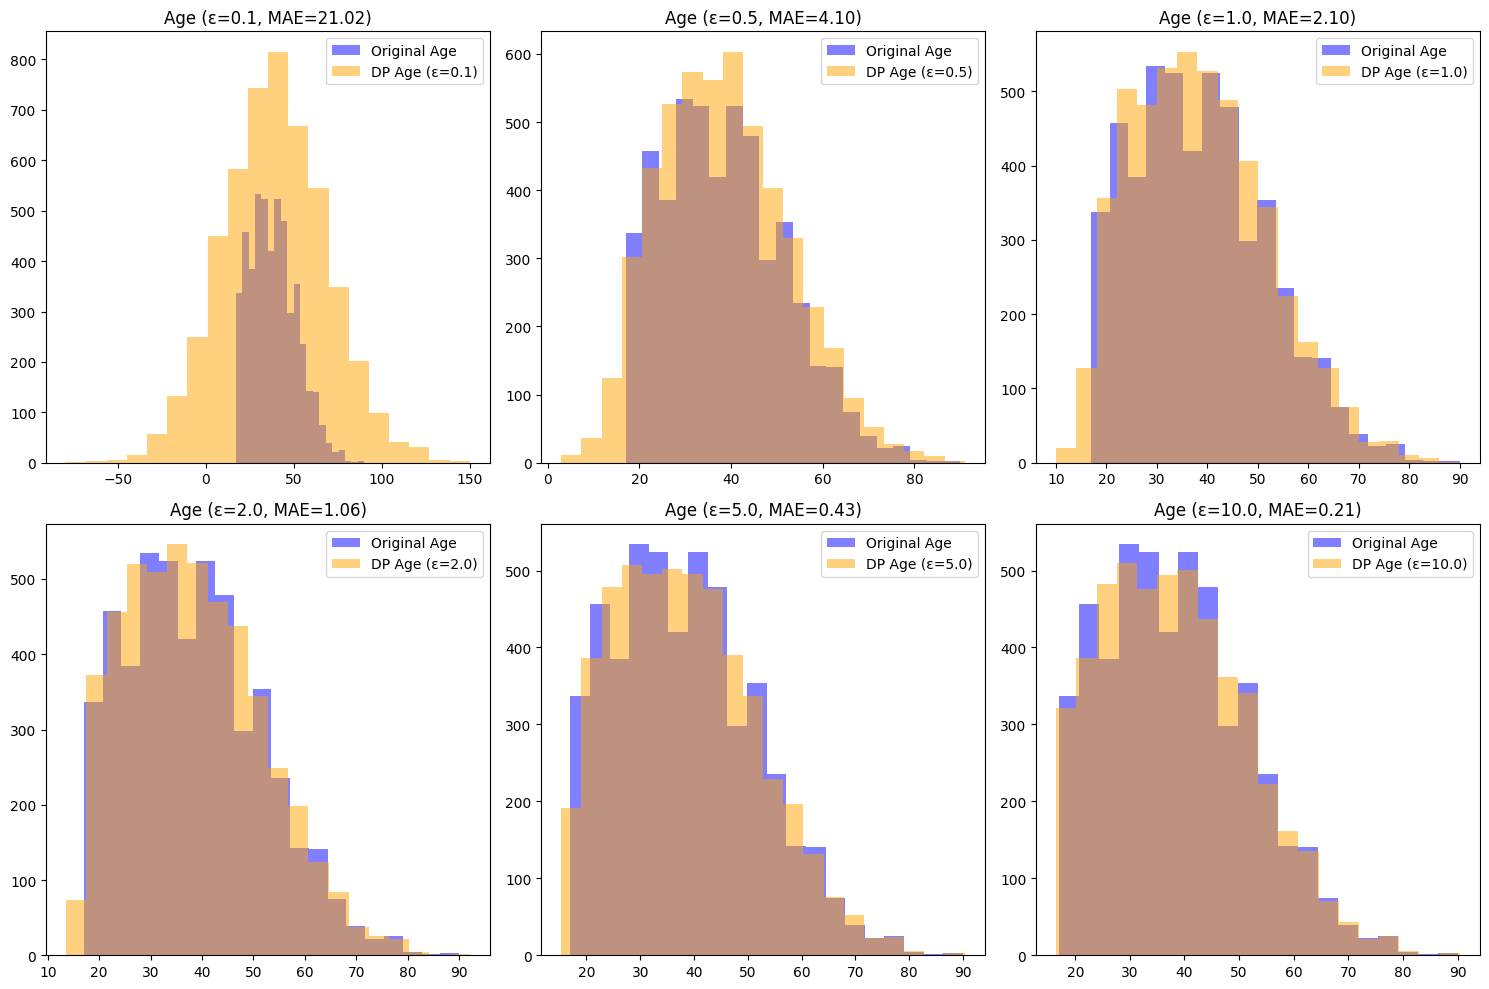

In [11]:
# Histograms age versus income
results_age = {float(k): v for k, v in results_age.items()}
results_education = {float(k): v for k, v in results_education.items()}
results_age = dict(sorted(results_age.items()))
results_income = dict(sorted(results_education.items()))

original_age =  df_cleaned["age"].to_numpy()

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, (epsilon, data) in enumerate(results_age.items()):
    if i >= len(axes):
        break
    ax = axes[i]
    ax.hist(original_age, bins=20, alpha=0.5, label="Original Age", color='blue')
    ax.hist(data["dp_values"], bins=20, alpha=0.5, label=f"DP Age (ε={epsilon})", color='orange')
    ax.set_title(f"Age (ε={epsilon}, MAE={data['mae']:.2f})")
    ax.legend()

plt.tight_layout()
plt.show()

In [12]:
# metric to measure accuracy
print("\nPrivacy and Utility Metrics:")
print("---------------------------------------------------------")
print(f"{'Epsilon':<10}{'MAE':<10}{'EMD':<10}{'Stability':<12}{'Noise Variance':<15}")
print("---------------------------------------------------------")
for epsilon, data in results_age.items():
    print(f"{epsilon:<10}{data['mae']:.3f}     {data['emd']:.3f}     {data['stability']:.4f}       {data['noise_variance']:.4f}")


Privacy and Utility Metrics:
---------------------------------------------------------
Epsilon   MAE       EMD       Stability   Noise Variance 
---------------------------------------------------------
0.1       21.018     12.681     76.3088       6509.3956
0.5       4.101     0.777     15.1874       258.5642
1.0       2.098     0.354     7.5486       63.7135
2.0       1.063     0.275     3.8239       16.4010
5.0       0.426     0.254     1.5208       2.5971
10.0      0.211     0.198     0.7636       0.6523


   epsilon        MAE      SSIM
0      0.1  21.017539  0.884154
1      0.5   4.100686  0.893525
2      1.0   2.098222  0.900172
3      2.0   1.062868  0.911596
4      5.0   0.425736  0.917853
5     10.0   0.211349  0.923340


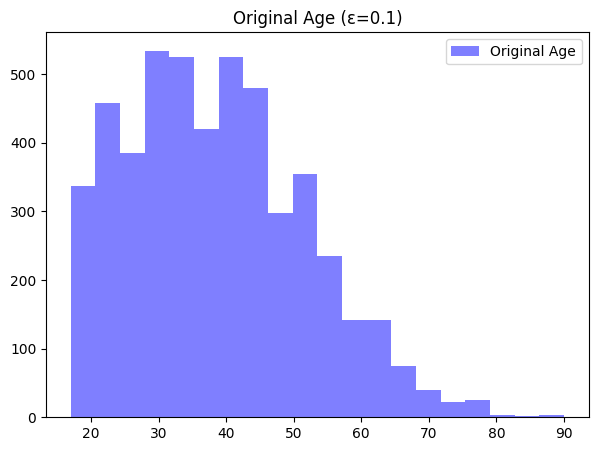

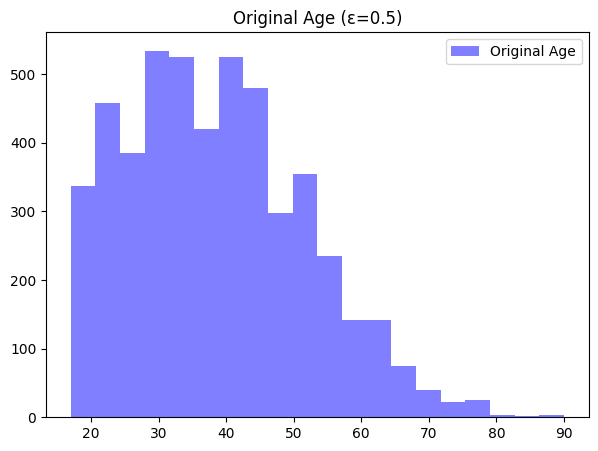

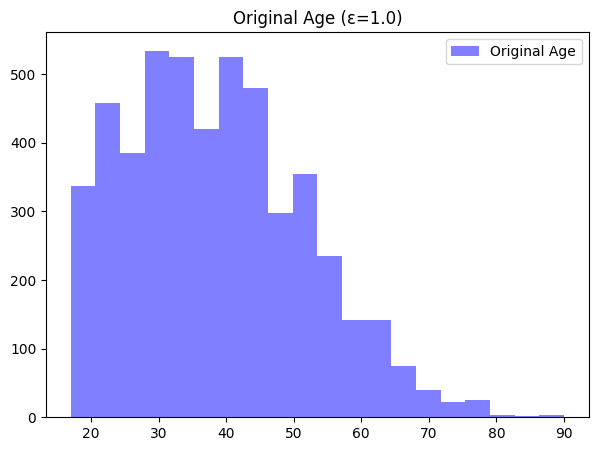

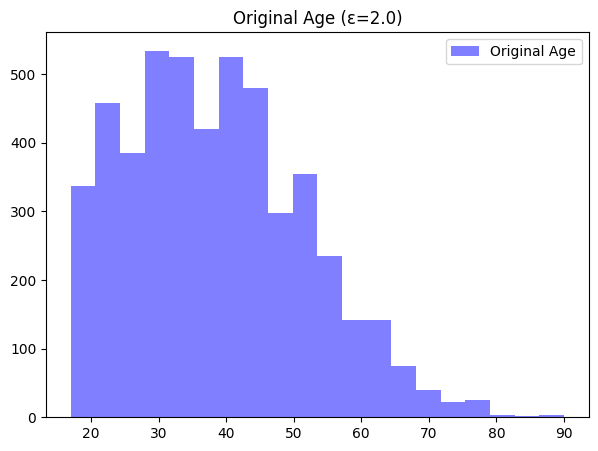

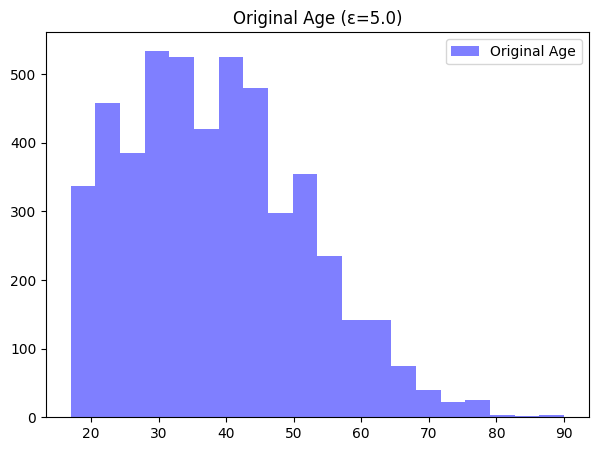

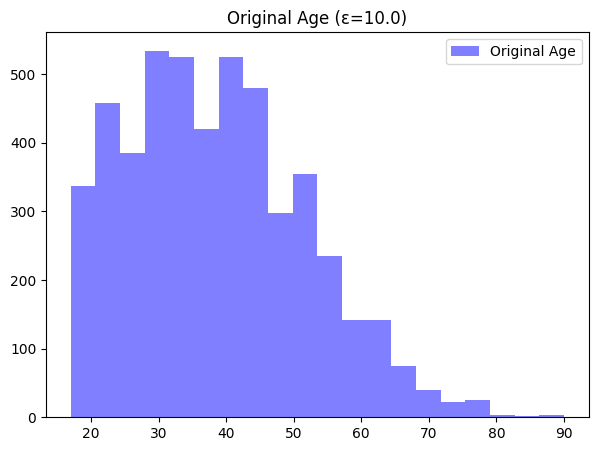

In [14]:
# SSIM analysis of heatmaps
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from skimage.metrics import structural_similarity as ssim
from io import BytesIO
from PIL import Image

# Function to convert a matplotlib Axes to grayscale image array
def get_grayscale_image_from_ax(ax):
    buf = BytesIO()
    fig = ax.get_figure()
    fig.savefig(buf, format='png')
    buf.seek(0)
    img = Image.open(buf).convert('L')
    return np.array(img)

ssim_scores = []

for i, (epsilon, data) in enumerate(results_age.items()):

    fig, ax = plt.subplots(figsize=(7, 5))
    ax.hist(original_age, bins=20, alpha=0.5, label="Original Age", color='blue')
    ax.set_title(f"Original Age (ε={epsilon})")
    ax.legend()

    # Get grayscale image of the original histogram
    original_img = get_grayscale_image_from_ax(ax)
    
    # Create histogram for DP values
    fig, ax = plt.subplots(figsize=(7, 5))
    ax.hist(data["dp_values"], bins=20, alpha=0.5, label=f"DP Age (ε={epsilon})", color='orange')
    ax.set_title(f"DP Age (ε={epsilon})")
    ax.legend()

    # Get grayscale image of the DP histogram
    dp_img = get_grayscale_image_from_ax(ax)

    # Compute SSIM between original and DP histograms
    score, _ = ssim(original_img, dp_img, full=True)
    ssim_scores.append({"epsilon": epsilon, "MAE": data["mae"], "SSIM": score})

    # Close the figures to avoid memory issues
    plt.close(fig)

# Convert SSIM results to DataFrame
ssim_df = pd.DataFrame(ssim_scores)
print(ssim_df)